<table style="background-color:#F5F5F5;" width="100%">
<tr><td style="background-color:#F5F5F5;"><img src="../images/logo.png" width="150" align='right'/></td></tr>     <tr><td>
            <h2><center>Aprendizagem Automática em Engenharia Biomédica</center></h2>
            <h3><center>1st Semester - 2022/2023</center></h3>
            <h4><center>Universidade Nova de Lisboa - Faculdade de Ciências e Tecnologia</center></h4>
</td></tr>
    <tr><td><h2><b><center>Lab 5 - Decision Trees and Model Optimization</center></b></h2>
    <h4><i><b><center>Human Activity Recognition with Decision Trees</center></b></i></h4></td></tr>
</table>

## 1. Classification Tasks

When working with ML-based classification, where one wants to model and predict a certain class or label. Depending on the problem, there are different strategies that may need to be adopted.

<div>
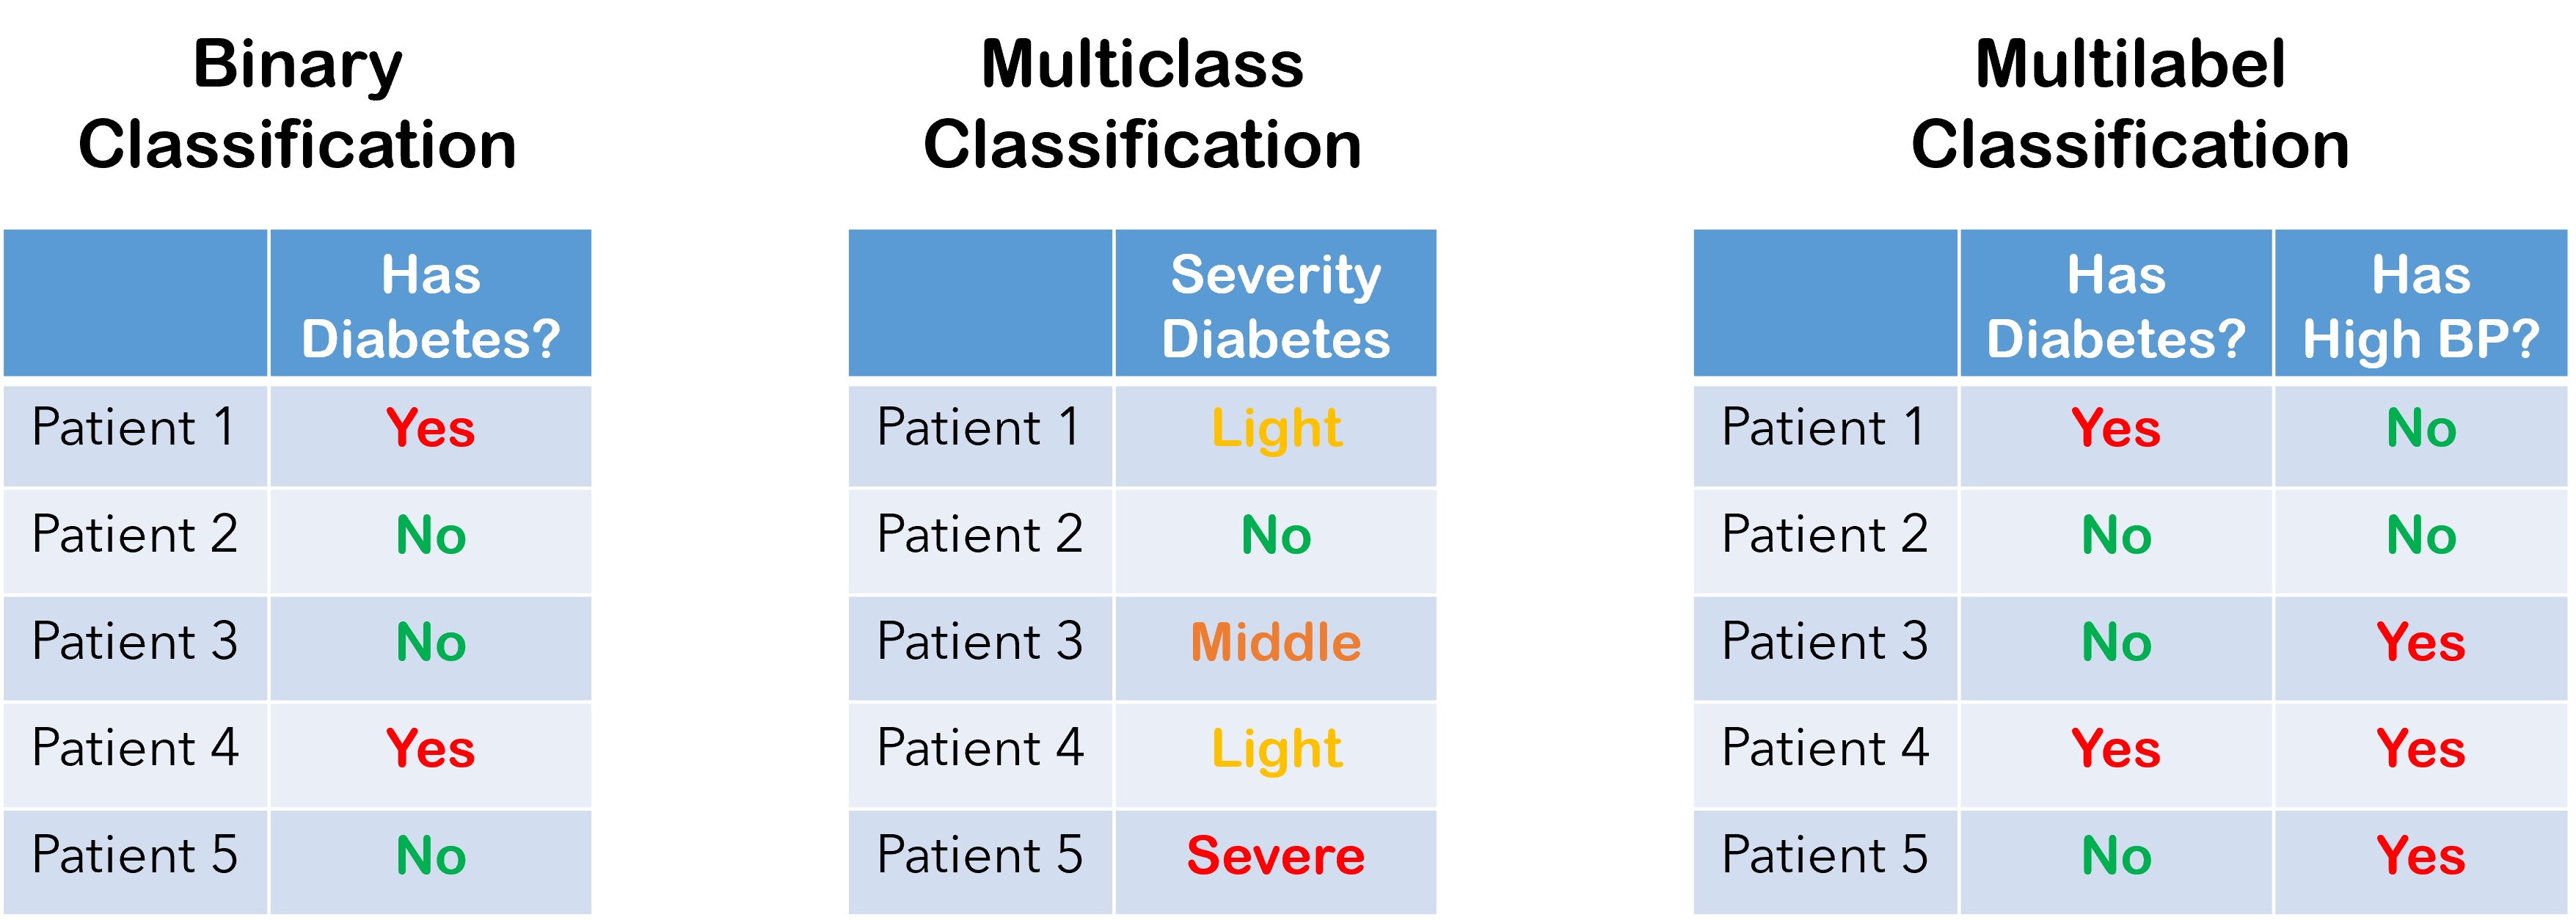
</div>

### 1.1. Exercice

__Exercice 1__: Give an example of a Biomedical-related ML problem that would fit each of above classification tasks.

## 2. Human Activity Recognition

Within the ML world, one common task is to predict different activities performed by humans, such as walking, running or standing. 

Since such activities change continuously, it is necessary to consider data collected throughout time, so one can predict the performed activity at any given moment. For this purpose, __time series__ are sets of temporal information collected by different sensors.

Movement sensors like the accelererometer are useful for the Human Activity Recognition (HAR) complext task. However, as models are not inherently prepared to process time series data, an additional step is necessary to include in the ML pipeline: __Feature Extraction__.

### 2.1. The _UCI Human Activity Recognition Using Smartphones Data Set_

Let's use a well-known HAR dataset from the [UCI repository](https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions):

_The experiments were carried out with a group of __30 volunteers__ within an age bracket of 19-48 years. They performed a protocol of activities composed of __six basic activities: three static postures (standing, sitting, lying) and three dynamic activities (walking, walking downstairs and walking upstairs)__. The experiment also included postural transitions that occurred between the static postures. These are: stand-to-sit, sit-to-stand, sit-to-lie, lie-to-sit, stand-to-lie, and lie-to-stand. All the participants were wearing a smartphone (Samsung Galaxy S II) on the waist during the experiment execution. We captured __3-axial linear acceleration and 3-axial angular velocity__ at a constant rate of __50Hz__ using the embedded accelerometer and gyroscope of the device. The experiments were video-recorded to label the data manually. The obtained dataset was randomly partitioned into two sets, where __70% of the volunteers was selected for generating the training data and 30% the test data__._

In this notebook, we will only use the X axis of the acceleration data.

In [ ]:
%matplotlib notebook
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sys import platform

The method `get_inertial_data()` performs the loading of one acceleration axis, including the original raw data and the corresponding labels. Furthermore, the id of the subject that performed the activity is also loaded.

In [ ]:
def get_inertial_data(acc_axis):
    
    # Load train data
    X_train = np.loadtxt('Data/UCI HAR Dataset/train/Inertial Signals/total_'+ acc_axis +'_train.txt')
    y_train = np.loadtxt('Data/UCI HAR Dataset/train/y_train.txt', dtype=int)
    subject_train = np.loadtxt('Data/UCI HAR Dataset/train/subject_train.txt', dtype=int)
    
    # Load test data
    X_test = np.loadtxt('Data/UCI HAR Dataset/test/Inertial Signals/total_'+ acc_axis +'_test.txt')
    y_test = np.loadtxt('Data/UCI HAR Dataset/test/y_test.txt', dtype=int)
    subject_test = np.loadtxt('Data/UCI HAR Dataset/test/subject_test.txt', dtype=int)

    # Load activity labels
    activity_labels = pd.read_csv('Data/UCI HAR Dataset/activity_labels.txt', index_col=0, header=None, sep=' ')
    
    return X_train, y_train, subject_train, X_test, y_test, subject_test, np.hstack(activity_labels.values)

In [ ]:
X_train, y_train, subject_train, X_test, y_test, subject_test, activity_labels = get_inertial_data('acc_x')

print("Train Data: X shape: {} | y shape: {} | Subjects: {}".format(X_train.shape, y_train.shape,np.unique(subject_train).size))
print("Test Data: X shape: {} | y shape: {} | Subjects: {}".format(X_test.shape, y_test.shape, np.unique(subject_test).size))
print("Available Activities:\n{}".format(activity_labels))

From above, we can see that our data is divided into windows of 128 samples, which sum to 2.56 seconds. We also know that they overlap by 50%.

As such, the model has 7352 windows to train, from 21 subjects. Therefore, there are multiple windows per subject.

Let's looks at the full data of one subject.

In [ ]:
subject = 1

stack_train = np.hstack(X_train[subject_train == subject, :64])

plt.figure()
plt.title("Acceleration Data from Subject {}".format(subject))
plt.plot(stack_train)
plt.vlines(np.where(np.diff(y_train[subject_train == subject]) != 0)[0] * 64 , -.5, 2, color='orange')

In [ ]:
stack_train = np.hstack(X_train[subject_train == subject, :64])

plt.figure()
plt.title("Window from Subject {}".format(subject))
plt.plot(X_train[subject_train == subject][100])

## 2.2. Feature Extraction

Models need to learn from useful characteristics from each data sample, i.e. window. For that purpose, it is necessary to extract features from the signals.

From the above plot we can see that there are significant differences in the amplitude of each activity. In this example, we will calculate some features, such as `np.mean()`, `np.max()` and `np.min()`, for every window. Then, we will evaluate if it is enough to distinguish our classes.

In [ ]:
def compute_statistical_features(X):
    mean_feat = np.mean(X, axis=1)
    max_feat = np.max(X, axis=1)
    min_feat = np.min(X, axis=1)
    
    return np.vstack([mean_feat, max_feat, min_feat]).T

In [ ]:
X_train_stat = compute_statistical_features(X_train)
X_test_stat = compute_statistical_features(X_test)

X_train_stat[:5]

Now, it is important to verify if our data is balanced, as it may present problems.

In [ ]:
plt.figure()
plt.title("Distribution of Classification Samples")
plt.hist(y_train, range=[1,7], bins=6, width=0.8)
plt.xticks(np.arange(1,7), activity_labels, rotation=45)
plt.tight_layout()

### 2.3. Automatic Feature Extraction with TSFEL

Another method to extract useful information from data is to leverage automatic feature extraction tools, which can compute in an efficient way more informative representations of our data.

For time series data, the Time Series Feature Extraction Library ([TSFEL](https://tsfel.readthedocs.io/en/latest/)) is able to extract features from the temporal, statistical and spectral domains. 

We will try this tool in the Human Activity Recognition Dataset, but first we need to install it. Run on your terminal:

`pip install tsfel`

Let's see how it works on a subset of the train set. The computation process takes some time. 

In [ ]:
import tsfel

cfg = tsfel.get_features_by_domain()

X_train_tsfel = tsfel.time_series_features_extractor(cfg, X_train[::100], fs=50)

In [ ]:
X_train_tsfel.head()

### 2.4. Exercice

__Exercice 2__: Extract features from the TSFEL library on the complete train and test sets.

## 3. Decision Tree Models

Decision Tree is one of the most widely used ML algorithms. In this method, the learning function that maps a set of variables into the target is represented by a decision tree. Such trees can also be represented as sets of if-then rules for human readability.

<div>
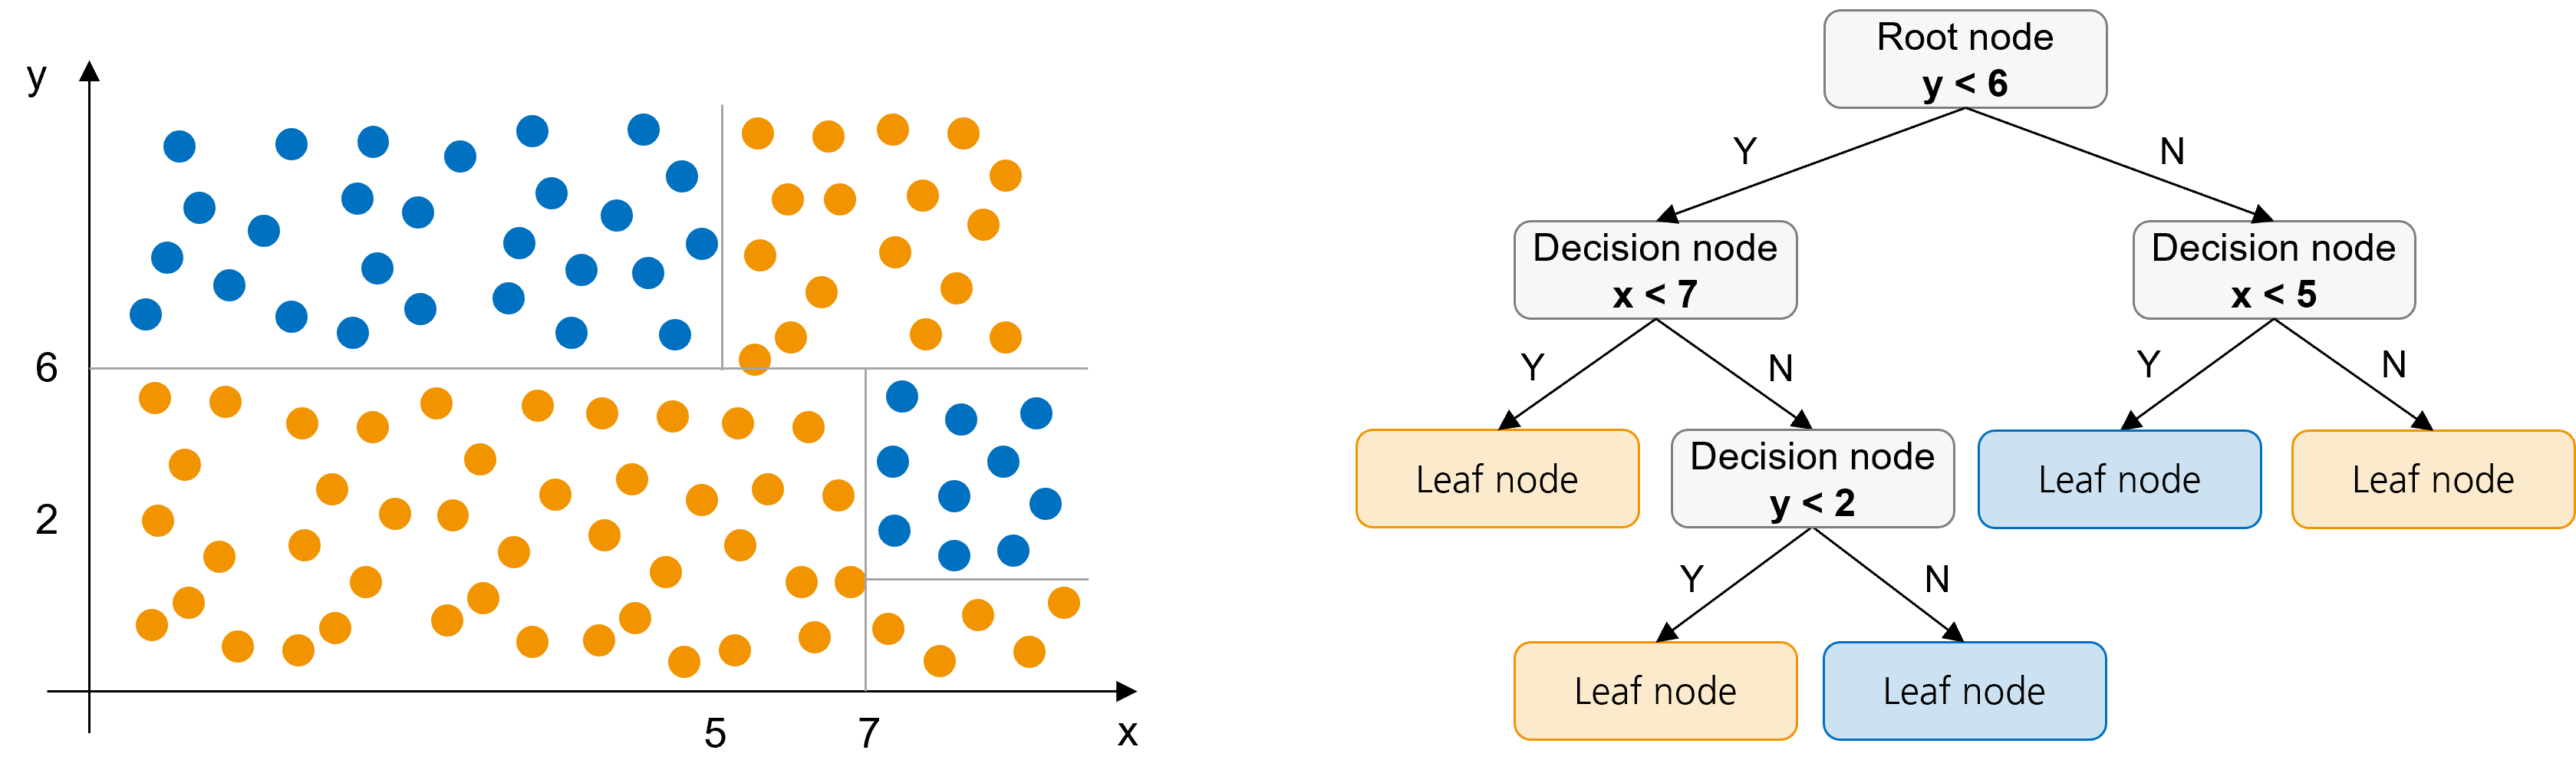
</div>

When looking at a decision tree, there are some important concepts to take into consideration:

* __Root node__: The top node of a decision tree from which all node splits come from. It represents the entire population.

* __Decision nodes__: These are nodes which are subdivided into new branches. Similarly, __parent nodes__ are those divided into sub-nodes, and these are called the __child nodes__.

* __Leaf or Terminal nodes__: Includes all nodes that are not further subdivided, thus representing the predicted class.

Decision Trees therefore classify samples by sorting them down from the root of the tree up to some leaf node, providing the final classification. Each node evaluates a specific attribute, which then divides the samples according to an optimized condition.

These models were originally developed for classification, although variations exist for the regression task. By dividing the multidimensional space into sections, these models are quite robust to outliers.

### 3.1. Optimizing Decision Trees

Training a decision tree is an iterative process towards an optimized solution. In simple terms, at each iteration, every data feature is tested to assert which is the most useful to classify the examples.

At every decision node, all features are tested, to select how the new branches will be created. The training continues using the training examples associated with each child node. The algorithm converges when no more samples are left to split, or when some stopping criteria is met.

##### 3.1.1. Entropy

One of the most common concepts related to the selection of decision features is _Entropy_. This measure characterizes the impurity of an arbitrary collection of examples, namely the set of samples available in some node. 

Entropy thus describes the purity of a node. The lower the value of entropy, the higher the node's purity. An homogeneous node has an entropy of 0. Therefore, the training process will create new subdivisions to lower the impurity of the system.

The entropy of a set of samples can be computed by the following equation:

$$ \text{Entropy} = - \sum_{i=1}{p_i . \log_2{p_i}} $$

where $p_i$ is the probability of each class $i$ within the samples of the decision node. Entropy will be 1 when dealing with a binary classification problem the training set contains an equal proportion of both values, i.e. $p_i=0.5$. If all examples are from the same class, then the entropy will be 0.

The training process that uses entropy as a splitting strategy is called __Information Gain__, which is determined by:

$$ \text{Information Gain} = 1 - \text{Entropy}$$

The variable selection process will then exhaustively test the Information Gain brought by each feature.

##### 3.1.2. Gini Impurity

Another strategy often used is the Gini Impurity, which leverages the Gini concept. It translates the probability of correctly labeling a randomly chosen element if it was randomly labeled according to the distribution of labels in the node. It can be determined by:

$$ \text{Gini} = \sum_{i=1}{p_i^2} $$

Therefore, the Gini Impurity is determined by:

$$ \text{Gini Impurity} = 1 - \text{Gini}$$

### 3.2. Training a Decision Tree Classifier

Sklearn contains a method to train Decision Trees: the [`DecisionTreeClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

Let us train a Decision Tree based on the statistical features we extracted from the data.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier()

model.fit(X_train_stat, y_train)

We can compare the model results through the [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), a tool from the sklearn library to evaluate models.

In [ ]:
from sklearn.metrics import classification_report

y_test_pred = model.predict(X_test_stat)

print(classification_report(y_test, y_test_pred, target_names=activity_labels))

Also, we can compare the accuracy score from both the training and test sets.

In [ ]:
y_train_pred = model.predict(X_train_stat)

print('Train Accuracy: %.3f ' % accuracy_score(y_train_pred, y_train))
print('Test Accuracy : %.3f' % accuracy_score(y_test_pred, y_test))

### 3.3. The Overfitting Problem

From the results, we can clearly assert that our model is overfitted to the training data. We'll look at the optimized  decision tree, to see if we can verify this problem.

In [ ]:
from sklearn.tree import plot_tree

plt.figure()
plot_tree(model, filled=True)
plt.show()

As we let the learning process run with default values, the model converged into a perfect solution in the train set through a overly complex tree. This tree cannot generalize well to the test set.

Therefore, it is necessary to adjust the model hyperparameters, to impose some limitations to the training process. Sklearn offers some possibilities of adjustment.

### 3.4. Exercice

__Exercice 3__: Go to the `DecisionTreeClassifier()` web page and describe the different possibilities of hyperparameters.

* The splitter 
* The maximum depth
* The minimum number of samples required to split
* The minimum samples in each leaf
* The minimum weight fraction in each leaf
* The maximum number of features
* The maximum number of leaf nodes
* The minimum impurity decrease

## 4. Optimizing Machine Learning Models

While training ML models, we can chose a set of hyperparameters that will affect the learning process. However, each problem may require different values to attain the best performance.

As it is not possible to test all combinations by hand, it is useful to resort to additional optimization techniques: Cross Validation and Hyperparameter Tuning.

### 4.1. Cross Validation

Besides the evaluation of performance metrics, we usually need to implement more strategies to ensure that our model is not overfitted to training data, i.e. has generalization capacity.

One problem of pursuing the Train-Test splitting strategy is that, when we compare multiple models to select the best one, we are biasing the decision towards favouring the best test performance. From this process, we lose our impartial evaluation using the kept-out test set.

One strategy to avoid this problem is to apply Cross Validation while training. This process essentially consists on training some model multiple times, with different training sets, to evaluate if its performance is robust to slight variations.

<div>
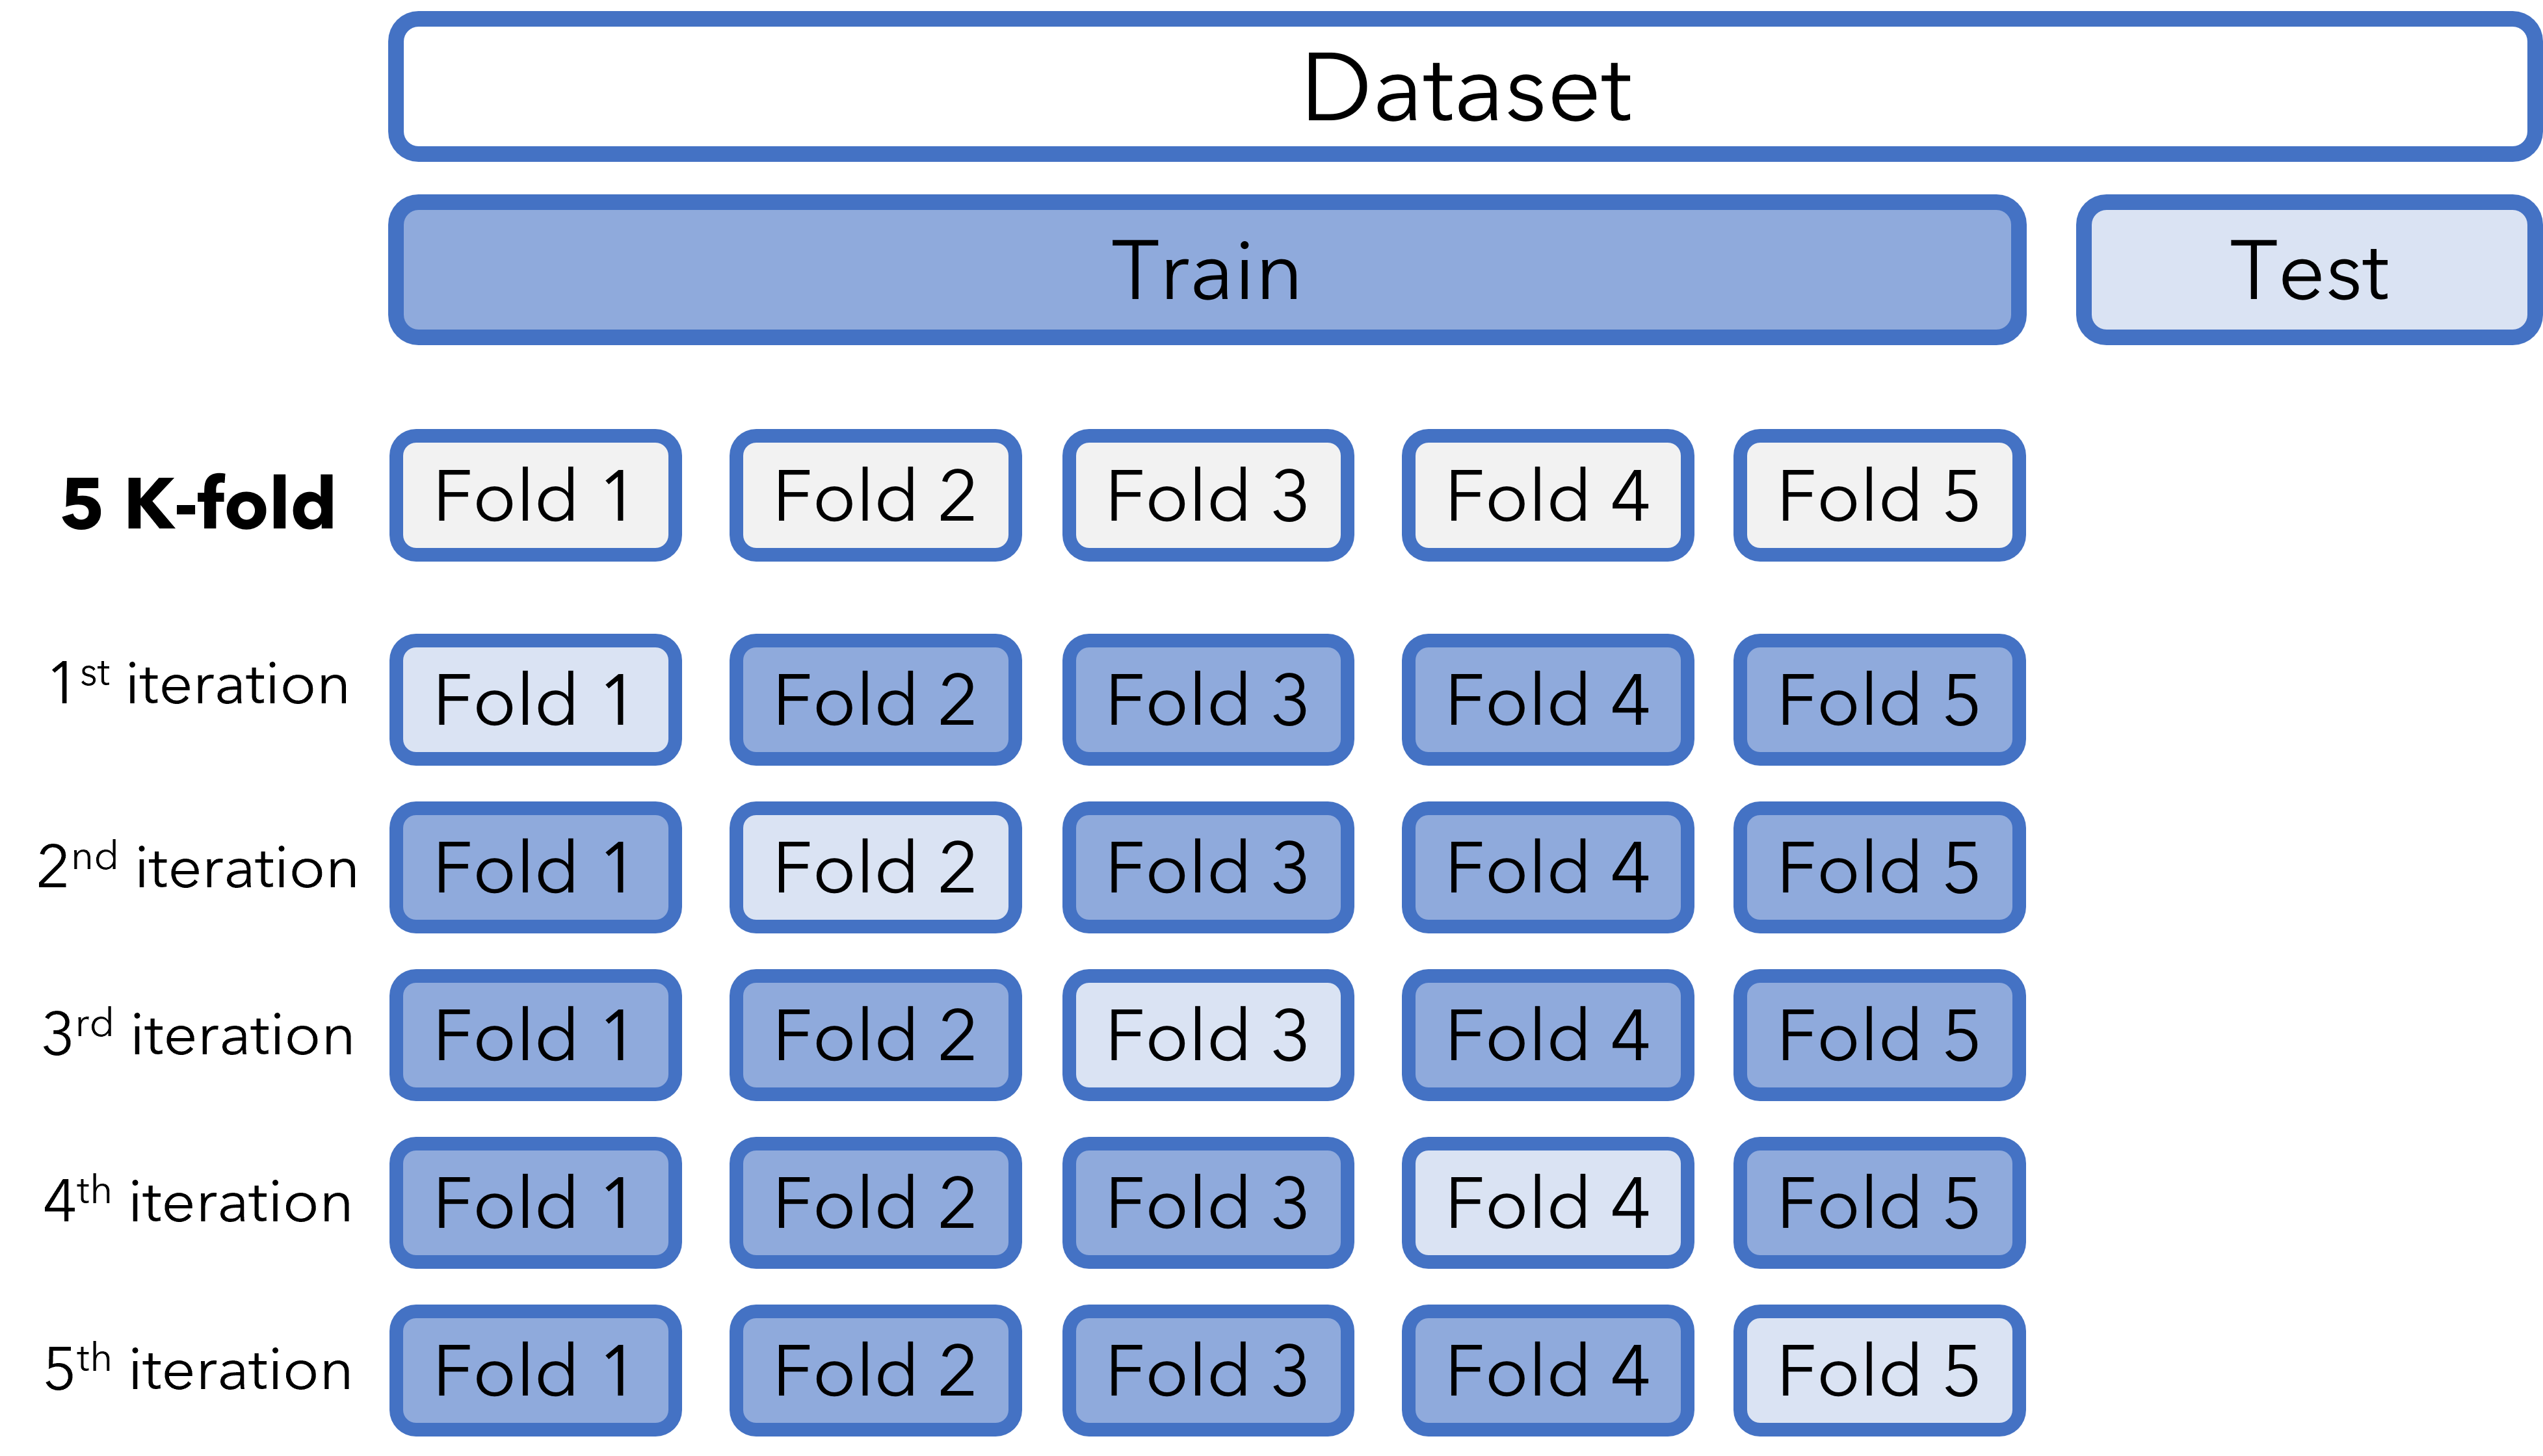
</div>

There are different strategies one can adopt:

* __K-Fold Cross Validation__: In this strategy, the dataset is split into K folds in either a ordered or random way. Each data sample will only be present in one fold. Then, iteratively, one fold is used as test set while all the other ones are used for training. The method from sklearn is [`KFold()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold).

* __Leave One Out Cross Validation__: This method will divide the dataset into multiple folds, where at each iteration all samples except one are used for training, while the excluded are used for test. Here, the number of training models matches the size of the dataset. Sklearn library provides the [`LeaveOneOut()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut) method for this purpose.

* __Shuffled Cross Validation__: As the name discloses, this strategy splits the dataset a predifined number of times (each for a training iteration), selecting the train and test samples randomly. [`ShuffleSplit()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit) implements this strategy.

##### 4.1.1. Grouped Cross Validation

In real world problems, we often find that datasets include multiple samples from one subject or group. If models get data splits disregarding this characteristic, the results will likely be overfitted, as the data seen in train is similar to the test set. Although performance metrics may not uncover this problem, when delivering the models to production, the training performance will drop.

For this purpose, sklearn library provides grouping strategies (e.g. [`GroupKFold()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold)). These variations take into account the information of the group each sample belongs to. Then, all samples from one group, such as all samples from one patient, are guaranteed to be present in a single fold.

##### 4.1.2. GroupKFold Cross Validation

In this work, we will use the `GroupKFold` strategy to split our data into 10 folds. We will only apply this process to the train set with the statistical features, while the original test set will be left for validation. Let's see how it works. 

In [ ]:
from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=10)

In [ ]:
group_kfold.get_n_splits(X_train_stat, y_train, subject_train)

In [ ]:
for train_index, test_index in group_kfold.split(X_train, y_train, subject_train):
    print("TRAIN:", train_index[:10], "TEST:", test_index[:10])

### 4.2. Hyperparameter Optimization

As it is not possible to test all combinations of hyperparameter manually, there are methods that perform the search across a predefined space automatically. Therefore, it is necessary to define the set of hyperparameters to test.

In the same way, there are some strategies available one can follow:

* __Grid Search__: This method iteratively tests all combinations of hyperparameters, to select which provides the best results. It can be applied using the [`GridSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) method from Sklearn.

* __Random Search__: This search algorithm randomly selects different combinations of hyperparameters until the predefined number of tests is met. We can implement this method through [`RandomizedSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) from Sklearn.

* __Bayesian Search__: Bayesian Optimization resorts to the Bayes Theorem to direct the search towards a global optimization. It builds a probabilistic model of the objective function, that is then searched efficiently with an acquisition function. This strategy can be implemented using the [`BayesSearchCV()`](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html) method from the scikit-optimize library.

These methods require the split the test set beforehand. Also, they inherently apply a cross validation strategy to test all possibilities. However, as we saw, some problems may require different split methods, namely when considering groups. Therefore, we can provide a cross validation splitter to the `cv` attribute of such functions.

##### 4.2.1. Random Search Hyperparameter Tuning

To understand how these type of optimization methods work, we will optimize the hyperparameters of the decision tree model using a random search strategy. As cross validation, the previous GroupKFold will be used.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

iterations = 100

param_grid = {
    'criterion': ['gini', 'entropy'],
    "max_depth": range(2, 6),
    'min_samples_split': [50, 100, 200],
    "min_samples_leaf": [25, 50, 100],
    "max_leaf_nodes": [10, 20, 30]
}

optimized_dt = RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_distributions=param_grid, 
                                  cv=group_kfold.split(X_train, y_train, subject_train), scoring='roc_auc_ovr_weighted', 
                                  verbose=2, n_iter=iterations, random_state=23, refit=True)

Let's us call the `fit()` method to optimize the hyperparameters and the `predict()`method so we can evaluate the results.

In [ ]:
optimized_dt.fit(X_train_stat, y_train)

In [ ]:
optimized_dt.best_score_

In [ ]:
optimized_dt.best_estimator_

In [ ]:
pd.DataFrame(optimized_dt.cv_results_).sort_values("mean_test_score", axis=0, ascending=False)

From this, we now know the best combination of hyperparameters (among the 100 runs) that optimizes the model towards the 10 test sets from cross validation. The AUROC for each split was obtained by the average weight of AUROCs of each class vs all the remaining.

Nevertheless, it is still important to validate the generalization capabilities of our model on the left out test set. Let's look at the Confusion Matrix.

In [ ]:
y_test_pred = optimized_dt.predict(X_test_stat)

In [ ]:
activity_labels

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=activity_labels, xticks_rotation="vertical")
plt.tight_layout()

### 4.3. Exercices

__Exercice 4__: Sklearn provides some variations of the KFold cross validation strategy. Go to the [`model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) page and check all KFold possibilities. Discuss their differences and objectives. 

__Exercice 5__: Evaluate the results of the optimized classifier using the three statistical features through the classification report from Sklearn. Discuss the results, namely by comparing between different classes and the aggregated ones. How they compare to the results from the train set?

__Exercice 6__: Following the attained results, we will now see how the model behaves against the more extent set of features from TSFEL. Therefore, optimize a Decision Tree model resorting to `GridSearchCV()` and using a `LeaveOneGroupOut()` strategy with the sets you extracted from the TSFEL library. As these data sets now includes more features, maybe we should limit the number of features leveraged by the model, as they come at a cost of complexity. Take a look at the `max_features` hyperparameter from the Decision Tree estimator.

_Hint_: The more hyperparameters you search, the longer the running will take. Try using the n_jobs option, which will distribute the computations across multiple cores.

__Exercice 7__: Evaluate these results and conclude which model and strategy are better for our Human Activity Recognition problem.